Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2631488
Academic license 2631488 - for non-commercial use only - registered to hu___@ogr.eskisehir.edu.tr
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2631488 - for non-commercial use only - registered to hu___@ogr.eskisehir.edu.tr
Optimize a model with 39 rows, 24 columns and 66 nonzeros
Model fingerprint: 0xad8139ac
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+01]
Presolve removed 34 rows and 12 columns
Presolve time: 0.01s
Presolved: 5 rows, 12 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9000000e+01   1.500000e+00   0.000000e+00      

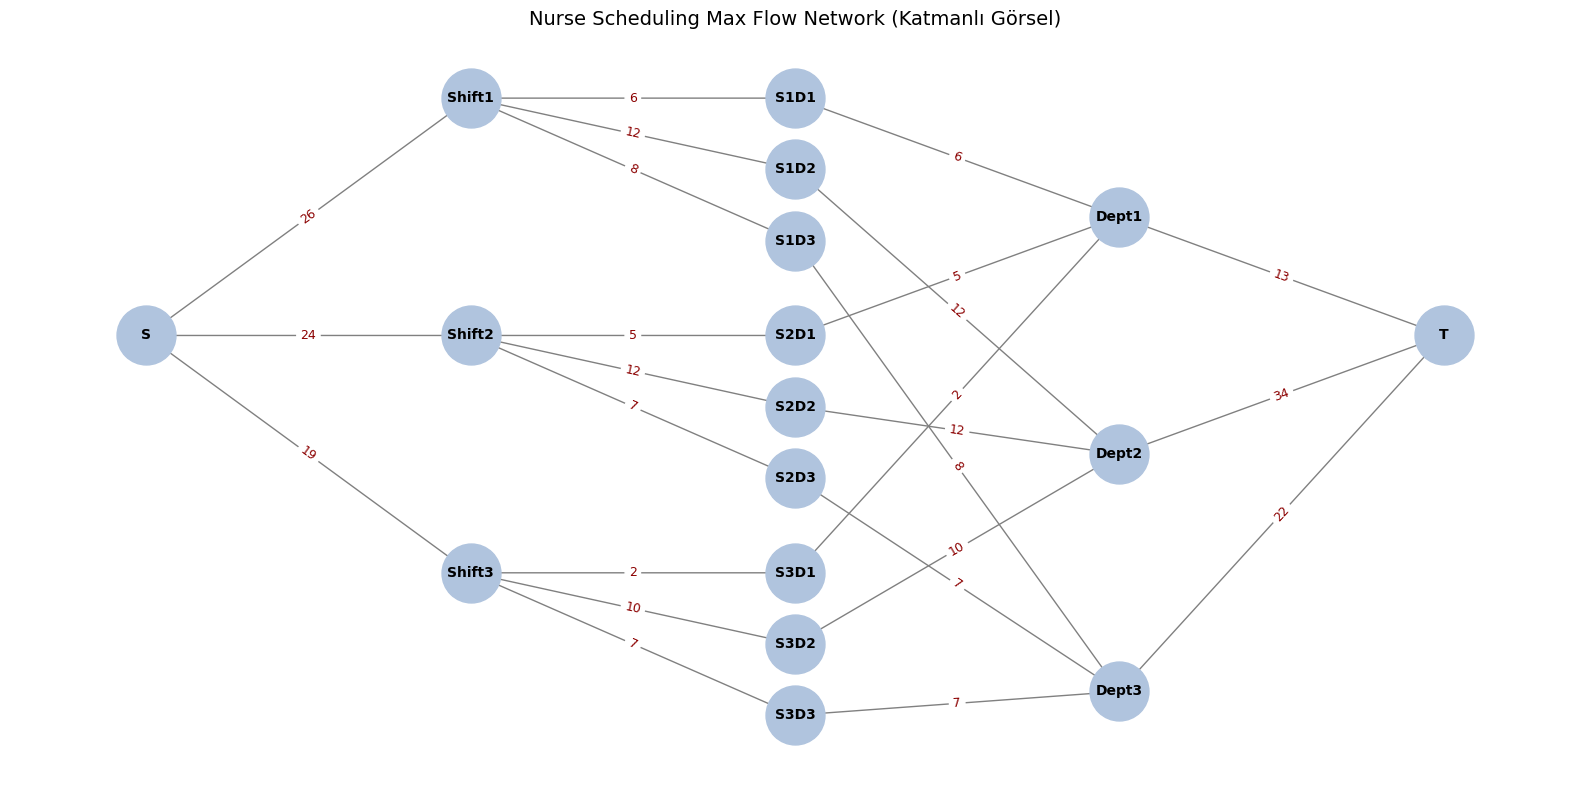

In [2]:
!pip install gurobipy networkx matplotlib

import gurobipy as gp
from gurobipy import GRB
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

params = {
    "WLSACCESSID": '5e515f08-0e42-48bd-9fc8-cac321d9fc57',
    "WLSSECRET": '2e0bcb85-f43c-4c6f-9421-fcdaf69ac602',
    "LICENSEID": 2631488,
}


env = gp.Env(params=params)
m = gp.Model("MaximumFlow_NurseScheduling", env=env)

shifts = [1, 2, 3]
departments = [1, 2, 3]
shift_reqs = {1: 26, 2: 24, 3: 19}
dept_reqs = {1: 13, 2: 32, 3: 22}
bounds = {
    (1, 1): (6, 8), (1, 2): (11, 12), (1, 3): (7, 12),
    (2, 1): (4, 6), (2, 2): (11, 12), (2, 3): (7, 12),
    (3, 1): (2, 4), (3, 2): (10, 12), (3, 3): (5, 7)
}

f_s_shift = m.addVars(shifts, lb=0.0, vtype=GRB.CONTINUOUS, name="f_s_shift")

f_shift_sd = m.addVars(shifts, departments, lb=0.0, vtype=GRB.CONTINUOUS, name="f_shift_sd")

f_sd_dept = m.addVars(shifts, departments, lb=0.0, vtype=GRB.CONTINUOUS, name="f_sd_dept")

f_dept_t = m.addVars(departments, lb=0.0, vtype=GRB.CONTINUOUS, name="f_dept_t")

m.addConstrs((f_sd_dept[s, d] <= bounds[(s, d)][1] for s in shifts for d in departments), name="Capacity_Upper")
m.addConstrs((f_sd_dept[s, d] >= bounds[(s, d)][0] for s in shifts for d in departments), name="Capacity_Lower")

m.addConstrs((f_s_shift[s] == gp.quicksum(f_shift_sd[s, d] for d in departments) for s in shifts), name="Flow_Shift")
m.addConstrs((f_shift_sd[s, d] == f_sd_dept[s, d] for s in shifts for d in departments), name="Flow_SD")

m.addConstrs((gp.quicksum(f_sd_dept[s, d] for s in shifts) == f_dept_t[d] for d in departments), name="Flow_Dept")
m.addConstrs((f_dept_t[d] >= dept_reqs[d] for d in departments), name="Dept_Demand")
m.addConstrs((f_s_shift[s] >= shift_reqs[s] for s in shifts), name="Shift_Demand")

m.setObjective(gp.quicksum(f_s_shift[s] for s in shifts), GRB.MINIMIZE)

m.optimize()

if m.status == GRB.OPTIMAL:
    print("Optimal objective value (Minimum Nurse Count):", m.objVal)
    for s in shifts:
        for d in departments:
            val = f_sd_dept[s, d].x
            if val > 0:
                print(f"Flow from Shift {s} to Department {d}: {val}")
else:
    print("Optimization was not successful. Status:", m.status)

m.write('Nurse_MaxFlow.lp')
m.write('Nurse_MaxFlow.sol')

G = nx.DiGraph()

edge_labels = {}

for s in shifts:
    val = f_s_shift[s].x
    G.add_edge("S", f"Shift{s}", weight=val)
    edge_labels[("S", f"Shift{s}")] = f"{val:.0f}"

for s in shifts:
    for d in departments:
        val1 = f_shift_sd[s, d].x
        val2 = f_sd_dept[s, d].x
        G.add_edge(f"Shift{s}", f"S{s}D{d}", weight=val1)
        edge_labels[(f"Shift{s}", f"S{s}D{d}")] = f"{val1:.0f}"
        G.add_edge(f"S{s}D{d}", f"Dept{d}", weight=val2)
        edge_labels[(f"S{s}D{d}", f"Dept{d}")] = f"{val2:.0f}"

for d in departments:
    val = f_dept_t[d].x
    G.add_edge(f"Dept{d}", "T", weight=val)
    edge_labels[(f"Dept{d}", "T")] = f"{val:.0f}"

pos = {}
pos["S"] = (-1, 0)
for i, s in enumerate(shifts):
    pos[f"Shift{s}"] = (0, 1 - i)
for i, s in enumerate(shifts):
    for j, d in enumerate(departments):
        pos[f"S{s}D{d}"] = (1, 1 - i - j * 0.3)
for i, d in enumerate(departments):
    pos[f"Dept{d}"] = (2, 0.5 - i)
pos["T"] = (3, 0)

plt.figure(figsize=(16, 8))
nx.draw_networkx_nodes(G, pos, node_size=1800, node_color="lightsteelblue")
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", arrowsize=20, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="darkred", font_size=9)

plt.title("Nurse Scheduling Max Flow Network (Katmanlı Görsel)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()